In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, 'functions/')
# from h5_tools import *
from tools import *
from fitting_tools import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import interpolate
import warnings
warnings.filterwarnings("ignore")

import scipy.interpolate
from scipy.ndimage import gaussian_filter

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

# Functions

In [2]:
def get_diff_coeff_library(filename='../03-source/diffusion_coefficient'):
    """Return dataframe with diffusion coefficients from the experimental data
    """
    df = pd.read_pickle(filename)
    df['temperature'] = df['temperature'].replace(243, 240)
    df['transmission'] = df['transmission'].str.replace('%', '')
    df['transmission'] = df['transmission'].str.replace('nan', '100')
    df['transmission'] = df['transmission'].str.replace('~', '')
    df['transmission'] = df['transmission'].astype(float)
    
    return df

def load_npz_data(filename):
    """Loads data from npz file and return a dictionary
    """
    file = np.load(filename)
    data = {key: file[key] for key in file.files}

    return data

# Load Viscosities

**From reference**

Text(0, 0.5, 'Viscosity (Ns/m$^2$)')

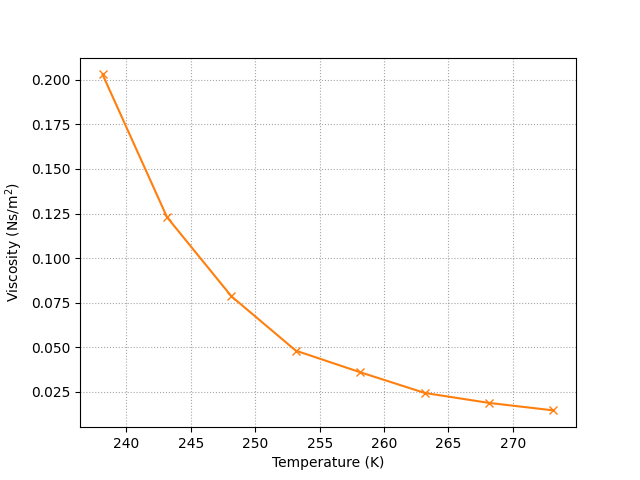

In [3]:
# form dx.doi.org/10.1021/je101164q |J. Chem. Eng. Data 2011, 56, 1397–1406 in mPa*s
eta_50w_ref = {273.15: 14.6, 268.15: 18.8, 263.15: 24.4, 258.15: 36.0, 253.15: 48.1, 248.15: 78.6, 243.15: 123, 238.15: 203}

lists = eta_50w_ref.items()
ts, etas_ref = zip(*lists)

plt.figure()
plt.plot(ts, np.array(etas_ref)*1e-3, label='50 w% = 23 mol% (paper)', marker='x', c='C1')

plt.xlabel("Temperature (K)")
plt.ylabel("Viscosity (Ns/m$^2$)")
# they overlap with the values in the pandas dataframe

In [4]:
# Rh = 5.785e-9
# Tsref, Dref = [], []

# for T in eta_50w_ref.keys():
#     Tsref.append(T)
#     # print(T, eta_50w_ref[T])
#     Dref.append(D_coeff(T=T, eta=eta_50w_ref[T]*1e-3, Rh=Rh))
# Dref

In [5]:
etas = viscosity()
etas#['50w%']

,temp,50w%,50v%,60v%,c1,c2,c3
0,300,0.004674,0.006357,0.011691,0.006726,0.008012,0.010947
1,290,0.006771,0.009497,0.018606,0.010106,0.012256,0.017301
2,280,0.010448,0.015197,0.032089,0.016282,0.020171,0.029595
3,270,0.017490,0.026578,0.061359,0.028708,0.036484,0.056042
4,260,0.032565,0.052163,0.134000,0.056900,0.074554,0.120980
5,250,0.069890,0.119340,0.348570,0.131720,0.179070,0.310370
6,240,0.182690,0.337190,1.149900,0.377570,0.536700,1.007000
7,230,0.635210,1.289300,5.300200,1.469200,2.204400,4.550300
8,220,3.416900,7.785200,40.015000,9.060500,14.508000,33.555000
9,210,37.846000,98.826000,657.370000,117.890000,203.600000,536.700000


In [6]:
# !ls ../03-source/

In [7]:
f = np.load("../03-source/viscosity_NP.npz") # 23 mol% = 50 w% = 44 v%
f_dls = np.load("../03-source/dls_NP_23mol.npz") # 23 mol% = 50 w% = 44 v%
f_dls.files

['D', 'dD', 'T']

# Plots

### Get Rh of NP from eta tabulated

In [8]:
print(f_dls['T'])
el_to_remove = np.array([264])

f_dls_T = np.setdiff1d(f_dls['T'], el_to_remove)
print(f_dls_T)

[263. 264. 268. 273. 278. 283. 288. 293. 298.]
[263. 268. 273. 278. 283. 288. 293. 298.]


In [9]:
f_dls_T_l = list(f_dls['T'])
f_dls_T_l.pop(1)
f_dls_T = np.array(f_dls_T_l)

f_dls_D_l = list(f_dls['D'])
f_dls_D_l.pop(1)
f_dls_D = np.array(f_dls_D_l)


f_dls_dD_l = list(f_dls['dD'])
f_dls_dD_l.pop(1)
f_dls_dD = np.array(f_dls_dD_l)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mass fraction of mixture = [0.61053332 0.60976477 0.60906042 0.60844673 0.60795691 0.60754145
 0.60718664 0.60688588]
Volume fraction of mixture = 0.5502212140839252
Mass fraction of mixture = [0.55167198 0.55087272 0.5501405  0.54950273 0.54899383 0.54856228
 0.5481938  0.54788151]
Volume fraction of mixture = 0.48986100446860603


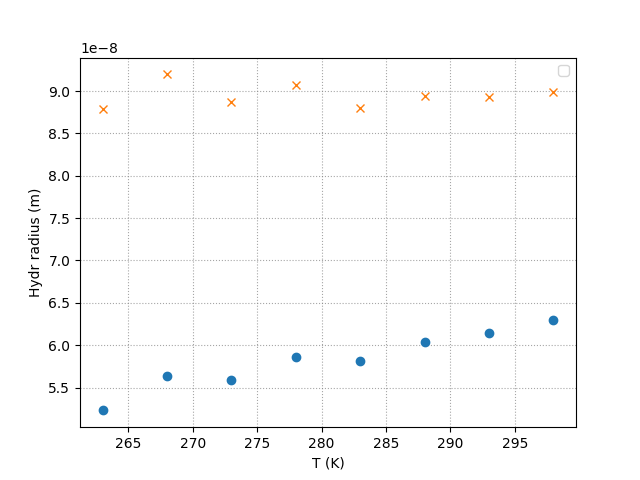

In [59]:
eta_dls = viscosity_glywater(f_dls_T - 273, weight_percent=0.607) # 19.2 #volume_percent=0.55) # Ns/m2

Kb = 1.3806e-23 # J/K

Rh_NP_DLS = f_dls_T * Kb / (6*np.pi * eta_dls * f_dls_D*1e-12)
Rh_NP_DLS2 = f_dls_T * Kb / (6*np.pi * eta_dls2 * f_dls_D*1e-12)


plt.figure()
plt.plot(f_dls_T, Rh_NP_DLS, ls='', marker='o')
plt.plot(f_dls_T, Rh_NP_DLS2, ls='', marker='x')

# Rh_dls = np.mean(Rh_NP_DLS)
# Rh2 = np.average(Rh_NP_DLS, weights=dRh_NP_DLS)

# plt.axhline(y=50e-9, label=f'{Rh_dls:.1e} m')
# plt.axhline(y=Rh2, label=f'{Rh2:.1e} m', c='r')
# plt.errorbar(f_dls['T'], Rh_NP_DLS*1e9, dRh_NP_DLS*1e9, ls='', marker='o')
plt.xlabel('T (K)')
plt.ylabel('Hydr radius (m)')
plt.legend()


### Viscosity vs Temperature

Mass fraction of mixture = [0.55167198 0.55087272 0.5501405  0.54950273 0.54899383 0.54856228
 0.5481938  0.54788151]
Volume fraction of mixture = 0.48986100446860603
Mass fraction of mixture = [0.55965922 0.5588628  0.55813316 0.55749761 0.55699046 0.55656038
 0.55619315 0.5558819 ]
Volume fraction of mixture = 0.49794728212606376


Text(0.5, 0, '$T$ (K)')

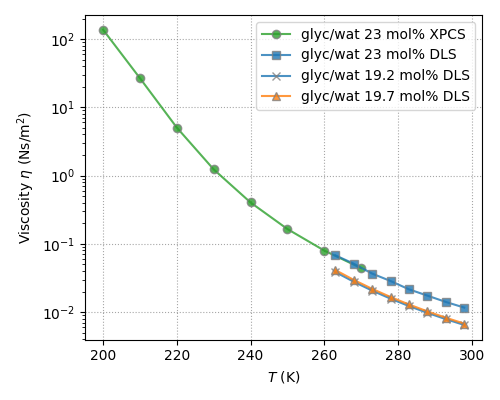

In [63]:
plt.figure(figsize=(5,4), tight_layout=True)

# plt.plot(f['T_gly'], f['eta_gly'], label='23 mol% (website)', c='C1', marker='o')
fact = 1.15

# from LLT ID10
# plt.plot(f['T_np'], f['eta_np'], label='NP 23 mol% (XPCS)', c='C2', marker='s')
# plt.plot(f['T_np'], f['eta_np']*fact, label='XPCS corrected', c='k', marker='x')
plt.plot(f['T_np'][1:], f['eta_np'][1:]*fact, label='glyc/wat 23 mol% XPCS', c='C2', mec='gray', alpha=0.8, marker='o')

# DLS NP100nm 23m/ol%
Rh_dls = 50e-9
eta_dls = f_dls_T*Kb / (6*np.pi* Rh_dls * f_dls_D*1e-12)

plt.plot(f_dls_T, eta_dls, label='glyc/wat 23 mol% DLS', c='C0', mec='gray', alpha=0.8, marker='s')#, mfc='none')

# 19 mol%
eta_dls_192 = viscosity_glywater(f_dls_T - 273, weight_percent=0.548) # 19.2 
eta_dls_197 = viscosity_glywater(f_dls_T - 273, weight_percent=0.556) # 19.2 
plt.plot(f_dls_T, eta_dls_192, label='glyc/wat 19.2 mol% DLS', c='C0', mec='gray', alpha=0.8, marker='x')#, mfc='none')
plt.plot(f_dls_T, eta_dls_197, label='glyc/wat 19.7 mol% DLS', c='C1', mec='gray', alpha=0.8, marker='^')#, mfc='none')

plt.yscale('log')
plt.legend()
# plt.xlim(190,310)
# plt.ylim(1e-3,1e3)
# plt.ylim(1e-2,4e-1)
# plt.xlim(240,280)
# plt.ylabel("$\eta$ (Pa$\cdot$s)")
plt.ylabel("Viscosity $\eta$ (Ns/m$^2$)")
plt.xlabel("$T$ (K)")

# plt.savefig('../06-figs/eta_id10_llt.png', dpi=300)

In [45]:
etas_NP = np.concatenate((f['eta_np']*fact, eta_dls))
Ts_NP = np.concatenate((f['T_np'], f_dls_T))
np.shape(etas_NP)

(17,)

## Rescale viscosity for 19 mol% glycerol

In [46]:
T_19 = np.array([263, 264, 268, 273, 278, 283, 288, 293, 298]) #np.arange(263, 300, 5)
print(T_19)
eta_19 = viscosity_glywater(T_19-273, volume_percent=0.489)

[263 264 268 273 278 283 288 293 298]
Mass fraction of mixture = [0.55081964 0.55065486 0.5500201  0.54928763 0.54864964 0.54814056
 0.54770888 0.54734028 0.54702788]
Volume fraction of mixture = 0.489


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


r = 1.82 ± 0.04


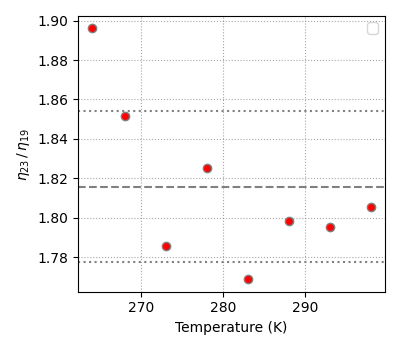

In [54]:
plt.figure(figsize=(4,3.5))

# -- 23 mol% glycerol
eta_19_r = eta_19[::-1]
eta_23_r = etas_NP[::-1]
T_19_r = T_19[::-1]

r = []
for i in range(len(T_19_r[:-1])):
    r.append(eta_23_r[i] / eta_19_r[i])
    plt.plot(T_19_r[i], eta_23_r[i] / eta_19_r[i], ls='', marker='o', c='r', mec='gray')


plt.axhline(y = np.mean(r), ls='--', c='gray')
plt.axhline(y = np.mean(r) + np.std(r), ls=':', c='gray')
plt.axhline(y = np.mean(r) - np.std(r), ls=':', c='gray')
print(f'r = {np.mean(r):.2f} ± {np.std(r):.2f}')
# -- plot settings
plt.xlabel("Temperature (K)")
plt.ylabel("$\eta_{23}\,/\,\eta_{19}$ ")
plt.legend()
plt.tight_layout()

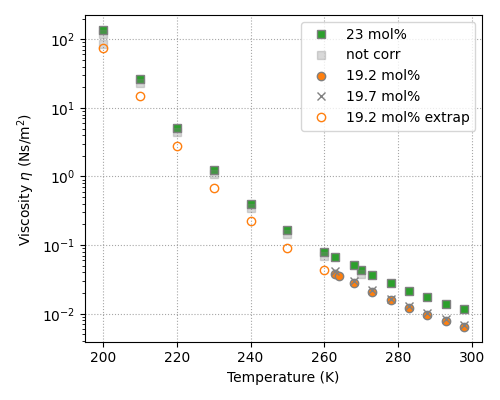

In [66]:
plt.figure(figsize=(5,4))

# -- 23 mol% glycerol
plt.plot(Ts_NP[1:], etas_NP[1:], ls='', marker='s', c='C2', mec='gray', label='23 mol%')
plt.plot(f['T_np'], f['eta_np'], ls='', marker='s', c='gray', alpha=0.3, label='not corr')


# -- 19 mol% glycerol
plt.plot(T_19, eta_19, ls='', marker='o', c='C1', mec='gray', label='19.2 mol%')
plt.plot(f_dls_T, eta_dls_197, ls='', marker='x', c='C1', mec='gray', label='19.7 mol%')

rescale = np.mean(r)
plt.plot(Ts_NP[1:8], etas_NP[1:8] / rescale, ls='', marker='o', c='C1', mfc='none', label='19.2 mol% extrap')
# -- plot settings
plt.xlabel("Temperature (K)")
plt.ylabel("Viscosity $\eta$ (Ns/m$^2$) ")
plt.yscale('log')
plt.legend()
plt.tight_layout()

In [16]:
# np.savez("../03-source/viscosity_fit_19mol", T_high=T_19, eta_high=eta_19, T_low=Ts_NP[1:8], eta_low=etas_NP[1:8] / rescale)
# np.savez("../03-source/viscosity_fit_23mol", T=Ts_NP[1:], eta=etas_NP[1:])
# np.savez("../03-source/viscosity_fit_23mol", )

In [17]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

eta_19_lowT = []
T_19_lowT = []

for t in Ts_NP:
    index =  find_nearest(new_x, t)
    print(t, index, result[index]/rescale)
    eta_19_lowT.append(result[index] / rescale)
    T_19_lowT.append(t)

NameError: name 'Ts_NP' is not defined

**Useless Fits**

In [ ]:
def visc_fit(T,a,b,c,d):
    eta_T = a * np.exp((b+T)*T/(c+d*T))
    return eta_T

def visc2(T, A,Q,R):
    """ Check here https://en.wikipedia.org/wiki/Viscosity (Amorphous materials)
    """
    return A*np.exp(Q/(R*T))

def visc3(T, A, B, C, D, R,):
    mu = A * T * np.exp( B/(R*T) ) * (1 + C*np.exp( D/(R*T) ))
    return mu

def visc4(T, V,C,lamb,alpha,Tg):
    Kb = 1.3806e-23 # J/K
    mu = np.exp(  (V*C) / (Kb*T) * np.exp( (2+lamb)*alpha*Tg*(1-T/Tg) )  )
    return mu


In [ ]:
plt.figure()

plt.plot(Ts_NP[1:], etas_NP[1:], ls='', marker='o', c='r', mec='gray', label='experimental')

ll1 = 7
popt,xc,curve,perr = fit(visc2, Ts_NP[1:ll1], etas_NP[1:ll1], p0=[ 1e-12, -6e+04, -10])
# print(popt)
plt.plot(xc, curve, c='k')

# this is pretty good
ll = 12
popt,xc,curve,perr = fit(visc2, Ts_NP[-ll:], etas_NP[-ll:], p0=[1e-12, -2e4, -4])
plt.plot(xc, curve, c='k')

# popt,xc,curve,perr = fit(visc3, Ts_NP, etas_NP)#, p0=[1e-12, -2e4, -4])
# print(popt)
# plt.plot(xc, curve, c='k')

# intermediate temps
# popt,xc,curve,perr = fit(visc3, Ts_NP[ll1-2:ll1+6], etas_NP[ll1-2:ll1+6])#, p0=[ 1e-12, -6e+04, -10])
l1, l2 = 3,-6
popt,xc,curve,perr = fit(visc3, Ts_NP[l1:l2], etas_NP[l1:l2])
print(popt)
# plt.plot(xc, curve, c='C2')

# l1, l2 = 4, -7
# popt,xc,curve,perr = fit(visc4, Ts_NP[l1:l2], etas_NP[l1:l2])#, bounds=[(None,None, None,None,0), (None,None,None,None,None)]) # V,C,lamb,alpha,Tg)
# print(popt)
# plt.plot(xc, curve, c='C0')

plt.xlabel("Temperature (K)")
plt.ylabel("Viscosity $\eta$ (Ns/m$^2$) ")
plt.yscale('log')
# plt.ylim(0,150)
# plt.ylim(1e-1,4e2)
# plt.ylim(8e-3,1e-1)

In [74]:
# !ls ../03-source/

In [134]:
# np.savez("../03-source/viscosity_fit", T=new_x, eta=result)
# np.savez("../03-source/viscosity_fit_19mol", T=T_19_lowT, eta=eta_19_lowT)

Text(0.5, 0, '$T$ (K)')

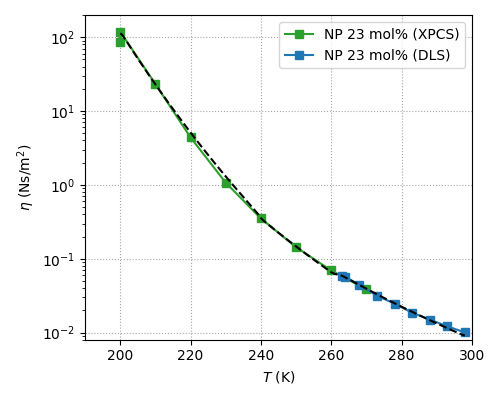

In [136]:
plt.figure(figsize=(5,4), tight_layout=True)

# from LLT ID10
plt.plot(f['T_np'], f['eta_np'], label='NP 23 mol% (XPCS)', c='C2', marker='s')

# DLS NP100nm 23mol%
eta_dls = f_dls['T']*Kb / (6*np.pi* Rh_dls * f_dls['D']*1e-12)
ff =  f_dls['T']*Kb / (6*np.pi*Rh_dls)

deta_dls = ff *  f_dls['dD']*1e-12 / (f_dls['D']*1e-12)**2

plt.plot(f_dls['T'], eta_dls, label='NP 23 mol% (DLS)', c='C0', marker='s')#, mfc='none')

plt.plot(new_x, result, ls='--', c='k')

plt.yscale('log')
plt.legend()
plt.xlim(190,300)
plt.ylim(8e-3,2e2)
# plt.ylabel("$\eta$ (Pa$\cdot$s)")
plt.ylabel("$\eta$ (Ns/m$^2$)")
plt.xlabel("$T$ (K)")
# plt.ylim(1e-2,1e-1)

# plt.savefig('../06-figs/eta_id10_llt.png', dpi=300)

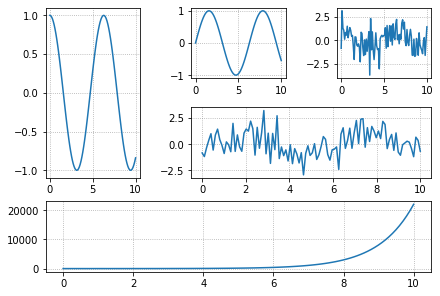

In [ ]:
fig, ax = plt.subplot_mosaic([['A', 'B', 'C'], ['A', 'D', 'D'], ['E', 'E', 'E']],
                              layout='constrained')

x = np.linspace(0,10,100)

ax['A'].plot(x, np.cos(x))
ax['B'].plot(x, np.sin(x))
ax['C'].plot(x, np.cos(x)+np.random.normal(0, 1, len(x)))
ax['D'].plot(x, np.sin(x)+np.random.normal(0, 1, len(x)))
ax['E'].plot(x, np.exp(x)+np.random.normal(0, 1, len(x)))